In [1]:
import os
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, classification_report
import torchvision.models as models

import torch
import torch.nn.functional as F
from torch.utils import data
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim
import re
import tsfresh as tsf

# 读取数据

In [2]:
files_path = './FBDQA2021A_MMP_Challenge/train_data.csv'
df =  pd.read_csv(files_path)
df = df.sort_values(by=['sym','date','date_time'])

In [3]:
# #动量因子
# def MOM(close_price, n):
#     return pd.Series(close_price).diff(n)
# #均线因子
# def MA(close_price, n):
#     return pd.Series(close_price).rolling(n).mean()
# #相对强弱指标：
# def RSI(close_price, n):
#     diff = pd.Series(close_price).diff()
#     up, down = diff.copy(), diff.copy()
#     up[up < 0] = 0
#     down[down > 0] = 0
#     up_sma = up.rolling(n).mean()
#     down_sma = abs(down.rolling(n).mean())
#     rs = up_sma / down_sma
#     return 100 - (100 / (1 + rs))
# #布林带指标
# def BBANDS(close_price, n):
#     ma = pd.Series(close_price).rolling(n).mean()
#     std = pd.Series(close_price).rolling(n).std()
#     upper_band = ma + 2 * std
#     lower_band = ma - 2 * std
#     # print(upper_band)
#     return upper_band, lower_band



In [4]:
df['spread1'] =  df['ask1'] - df['bid1']
df['spread2'] =  df['ask2'] - df['bid2']
df['spread3'] =  df['ask3'] - df['bid3']
df['mid_price1'] =  df['ask1'] + df['bid1']
df['mid_price2'] =  df['ask2'] + df['bid2']
df['mid_price3'] =  df['ask3'] + df['bid3']

# 价格+1（从涨跌幅还原到对前收盘价的比例）
df['bid1'] = df['bid1']+1
df['bid2'] = df['bid2']+1
df['bid3'] = df['bid3']+1
df['bid4'] = df['bid4']+1
df['bid5'] = df['bid5']+1
df['ask1'] = df['ask1']+1
df['ask2'] = df['ask2']+1
df['ask3'] = df['ask3']+1
df['ask4'] = df['ask4']+1
df['ask5'] = df['ask5']+1

# 量价组合
df['weighted_ab1'] = (df['ask1'] * df['bsize1'] + df['bid1'] * df['asize1']) / (df['bsize1'] + df['asize1'])
df['weighted_ab2'] = (df['ask2'] * df['bsize2'] + df['bid2'] * df['asize2']) / (df['bsize2'] + df['asize2'])
df['weighted_ab3'] = (df['ask3'] * df['bsize3'] + df['bid3'] * df['asize3']) / (df['bsize3'] + df['asize3'])

df['vol1_rel_diff']   = (df['bsize1'] - df['asize1']) / (df['bsize1'] + df['asize1'])
df['volall_rel_diff'] = (df['bsize1'] + df['bsize2'] + df['bsize3'] + df['bsize4'] + df['bsize5'] \
                 - df['asize1'] - df['asize2'] - df['asize3'] - df['asize4'] - df['asize5'] ) / \
                 ( df['bsize1'] + df['bsize2'] + df['bsize3'] + df['bsize4'] + df['bsize5'] \
                 + df['asize1'] + df['asize2'] + df['asize3'] + df['asize4'] + df['asize5'] )

df['amount'] = df['amount_delta'].map(np.log1p)

# 价格还原
df['bid1'] = df['bid1']-1
df['bid2'] = df['bid2']-1
df['bid3'] = df['bid3']-1
df['bid4'] = df['bid4']-1
df['bid5'] = df['bid5']-1
df['ask1'] = df['ask1']-1
df['ask2'] = df['ask2']-1
df['ask3'] = df['ask3']-1
df['ask4'] = df['ask4']-1
df['ask5'] = df['ask5']-1

# #动量因子

# df['mom1'] = MOM(df['close'], 1)
# df['mom5'] = MOM(df['close'], 5)
# df['mom10'] = MOM(df['close'], 10)
# df['mom20'] = MOM(df['close'], 20)

# #均线因子
# df['ma5'] = MA(df['close'], 5)
# df['ma10'] = MA(df['close'], 10)
# df['ma20']= MA(df['close'], 20)
# df['ma60'] = MA(df['close'], 60)

# #相对强弱指标
# df["rsi6"] = RSI(df['close'], 6)
# df["rsi12"] = RSI(df['close'], 12)
# df["rsi24"] = RSI(df['close'], 24)

# #布林带
# upper_band20, lower_band20 = BBANDS(df['close'], 20)
# df['upper_band20']= upper_band20 
# df['lower_band20']= lower_band20 
# upper_band60, lower_band60 = BBANDS(df['close'], 60)
# df['upper_band60']= upper_band60 
# df['lower_band60']= lower_band60 


In [5]:

# #价量趋势 这个会报错
# def PVT(close_price, amount_delta):
#     pvt = amount_delta * pd.Series(close_price).pct_change()
#     return pvt.cumsum()

# df['pvt'] = PVT(df['close'], df['amount_delta'])

#能量指标
# def EV(close_price, amount_delta, n):
#     return pd.Series(close_price.diff() * amount_delta.diff()).rolling(n).sum()

# df['ev5'] = EV(df['close'], df['amount_delta'], 5)
# df['ev10'] = EV(df['close'], df['amount_delta'], 10)
# df['ev20']= EV(df['close'], df['amount_delta'], 20)

In [6]:
# # tsfresh 挖掘因子
# param = [{'aggtype': 'centroid'}]
# data2pd= pd.Series(df['bsize5'])


# fft_col=tsf.feature_extraction.feature_calculators.fft_aggregated(data2pd, param)
# print(list(fft_col)[0][1])

In [7]:
# print(list(fft_col))

In [8]:
# print(len(data2pd))
# print(len(data2pd.index))

In [9]:
feature_col_names = ['bid1','bsize1',
                     'bid2','bsize2',
                     'bid3','bsize3',
                     'bid4','bsize4',
                     'bid5','bsize5',
                     'ask1','asize1',
                     'ask2','asize2',
                     'ask3','asize3',
                     'ask4','asize4',
                     'ask5','asize5',
                     'spread1','mid_price1',
                     'spread2','mid_price2',
                     'spread3','mid_price3',
                     'weighted_ab1','weighted_ab2','weighted_ab3','amount',
                     'vol1_rel_diff','volall_rel_diff',
                    ]
label_col_name = ['label_40']

In [10]:
n = len(df['date'].unique())

# ##划分训练/测试集
train_nums = int(n*0.8 + 0.5)
val_nums = int(n*0.1 + 0.5)
print(f'train_date_nums: {train_nums}, val_date_nums: {val_nums}, test_date_nums: {n-train_nums-val_nums}')
train_data = df[df.date < train_nums]
val_data = df[(df.date >= train_nums) & (df.date < train_nums+val_nums)]
test_data = df[df.date >= train_nums+val_nums]

train_date_nums: 63, val_date_nums: 8, test_date_nums: 8


## GPU准备

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
# # 绝对傅里叶变换的谱统计量
# def fft_aggregated_transform(df):
#     # tsfresh 挖掘因子
#     param = [{'aggtype': 'centroid'}]
#     data2pd= pd.Series(df)

    
#     fft=list(tsf.feature_extraction.feature_calculators.fft_aggregated(data2pd, param))
    
#     return list(fft)[0][1]

# def fourier_entropy_transform(df):
#     ts = pd.Series(df)  #数据x假设已经获取
#     ae=tsf.feature_extraction.feature_calculators.fourier_entropy(ts,bins=10)
#     # print("fentropy{}".format(ae))
#     return ae

In [13]:
# def new_fft_lines(X,T):
#     X['fft'] = 0  # 初始化所有行的fft列为0
#     for i in range(T-1, len(X)):
#         X.iloc[i, X.columns.get_loc('fft')] = fft_aggregated_transform(X.iloc[(i-T+1):i, X.columns.get_loc('bsize5')])
#     return X
# def new_belowcount_lines(X,T):
#     X['belowcount'] = 0  # 初始化所有行的fft列为0
#     for i in range(T-1, len(X)):
#         X.iloc[i, X.columns.get_loc('belowcount')] = count_below_mean_transform(X.iloc[(i-T+1):i, X.columns.get_loc('belowcount')])
#     return np.abs(X-50)
# def new_abovecount_lines(X,T):
#     X['abovecount'] = 0  # 初始化所有行的fft列为0
#     for i in range(T-1, len(X)):
#         X.iloc[i, X.columns.get_loc('abovecount')] = count_above_mean_transform(X.iloc[(i-T+1):i, X.columns.get_loc('abovecount')])
#     return np.abs(X-50)
# def new_cwt_peaks_lines(X,T):
#     X['number_cwt_peaks'] = 0  # 初始化所有行的fft列为0
#     for i in range(T-1, len(X)):
#         X.iloc[i, X.columns.get_loc('number_cwt_peaks')] = number_cwt_peaks_transform(X.iloc[(i-T+1):i, X.columns.get_loc('number_cwt_peaks')])
#     return X
# def

In [14]:
# def new_lines(X,T):
#     # X['bid2_cwt_peaks'] = 0  # 初始化所有行的fft列为0
#     # X['bid4_cwt_peaks'] = 0  # 初始化所有行的fft列为0
#     # X['bid5_cwt_peaks'] = 0  # 初始化所有行的fft列为0
#     # X['abovecount'] = 0  # 初始化所有行的fft列为0
#     # X['belowcount'] = 0  # 初始化所有行的fft列为0
#     X['fft'] = 0  # 初始化所有行的fft列为0
#     X['bsize1_fourier_entropy'] = 0
#     X['bsize3_fourier_entropy'] = 0
    
#     for i in range(T-1, len(X)):
#         X.iloc[i, X.columns.get_loc('fft')] = fft_aggregated_transform(X.iloc[(i-T+1):i, X.columns.get_loc('bsize5')])
#         # X.iloc[i, X.columns.get_loc('belowcount')] = count_below_mean_transform(X.iloc[(i-T+1):i, X.columns.get_loc('asize5')])
#         # X.iloc[i, X.columns.get_loc('abovecount')] = count_above_mean_transform(X.iloc[(i-T+1):i, X.columns.get_loc('asize5')])
#         # X.iloc[i, X.columns.get_loc('bid2_cwt_peaks')] = number_cwt_peaks_transform(X.iloc[(i-T+1):i, X.columns.get_loc('bid2')])
#         # X.iloc[i, X.columns.get_loc('bid4_cwt_peaks')] = number_cwt_peaks_transform(X.iloc[(i-T+1):i, X.columns.get_loc('bid4')])
#         # X.iloc[i, X.columns.get_loc('bid5_cwt_peaks')] = number_cwt_peaks_transform(X.iloc[(i-T+1):i, X.columns.get_loc('bid5')])
#         X.iloc[i, X.columns.get_loc('bsize1_fourier_entropy')] = fourier_entropy_transform(X.iloc[(i-T+1):i, X.columns.get_loc('bsize1')])
#         X.iloc[i, X.columns.get_loc('bsize3_fourier_entropy')] = fourier_entropy_transform(X.iloc[(i-T+1):i, X.columns.get_loc('bsize3')])

        
#     return X

## 准备dataset

In [15]:
def data_transform(X, T):
    
    [N, D] = X.shape
    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = X[i - T:i, :]
    return dataX.tolist()

In [16]:
class Dataset(data.Dataset):
    def __init__(self, data, num_classes, T):
        self.T = T
        
        dates = data['date'].unique()
        syms = data['sym'].unique()
        data_result = []
        label_result = []
        for sym in syms:
            for date in dates:
                sym_date_df = data[(data.sym == sym)&(data.date == date)].copy()
                if len(sym_date_df) == 0:
                    continue
                #下面为tsfresh 特殊变换
                # print(sym_date_df['bsize5'])
                # sym_date_df = new_lines(sym_date_df,self.T)
#                 print(type(sym_date_df))
                
                data_result += data_transform(sym_date_df[feature_col_names].values, self.T)
                label_result += sym_date_df[label_col_name][T - 1:].values.tolist()
                
        self.x = torch.tensor(data_result).to(torch.float32).unsqueeze(1).to(device)
        label_result = np.array(label_result).reshape(-1)
        self.y = torch.tensor(label_result.astype(np.int64)).to(device)
        
        self.length = len(self.x)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [17]:
dataset_val   = Dataset(data=val_data, num_classes=3, T=100)
# dataset_test  = Dataset(data=test_data, num_classes=3, T=100)
# dataset_train = Dataset(data=train_data, num_classes=3, T=100)

In [18]:
dataset_test  = Dataset(data=test_data, num_classes=3, T=100)

In [19]:
dataset_train = Dataset(data=train_data, num_classes=3, T=100)

In [20]:
import pickle

# 获取当前文件所在路径的上一层路径
parent_dir = os.path.dirname(os.path.abspath(os.getcwd()))  # __file__表示当前文件名，可以用其他文件名替换
grandparent_dir = os.path.dirname(os.path.abspath(parent_dir))
# 输出上一层路径
print(parent_dir)
print(grandparent_dir)

# 保存 Dataset 对象到文件中
with open(grandparent_dir+'/dataset_train_new_diff_40.pickle', 'wb') as f:
    pickle.dump(dataset_train, f)
with open(grandparent_dir+'/dataset_test_new_diff_40.pickle', 'wb') as f:
    pickle.dump(dataset_test, f)
with open(grandparent_dir+'/dataset_val_new_diff_40.pickle', 'wb') as f:
    pickle.dump(dataset_val, f)

/home/yurh/quant
/home/yurh


In [21]:
# import pickle

# # 获取当前文件所在路径的上一层路径
# parent_dir = os.path.dirname(os.path.abspath(os.getcwd()))  # __file__表示当前文件名，可以用其他文件名替换
# grandparent_dir = os.path.dirname(os.path.abspath(parent_dir))
# # 输出上一层路径
# print(parent_dir)
# print(grandparent_dir)

# # 从文件中加载 Dataset 对象
# with open(grandparent_dir+'/dataset_train_old_diff.pickle', 'rb') as f:
#     dataset_train = pickle.load(f)
# with open(grandparent_dir+'/dataset_val_old_diff.pickle', 'rb') as f:
#     dataset_val = pickle.load(f)
# with open(grandparent_dir+'/dataset_test_old_diff.pickle', 'rb') as f:
#     dataset_test = pickle.load(f)

In [22]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader   = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader  = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

print(dataset_train.x.shape, dataset_train.y.shape, dataset_train.x.requires_grad, dataset_train.y.requires_grad,)
print(dataset_val.x.shape, dataset_val.y.shape, dataset_val.x.requires_grad, dataset_val.y.requires_grad,)
print(dataset_test.x.shape, dataset_test.y.shape, dataset_test.x.requires_grad, dataset_test.y.requires_grad,)

torch.Size([2348108, 1, 100, 32]) torch.Size([2348108]) False False
torch.Size([306022, 1, 100, 32]) torch.Size([306022]) False False
torch.Size([309921, 1, 100, 32]) torch.Size([309921]) False False


In [23]:
print(dataset_train.x.device)
print(dataset_train.y.device)

cuda:0
cuda:0


# 定义模型

In [24]:
from mmpc.model import ResNet50

In [25]:
model = ResNet50(num_classes = 3)
model.to(device);

# 训练模型

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0008, weight_decay=1e-5)

In [27]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    best_test_loss = np.inf
    best_test_epoch = 0
    step = 0
    save_step = 20000
    num_data_points = len(train_loader.dataset)
    train_losses = np.zeros((int(num_data_points/save_step)+1)*epochs)
    test_losses = np.zeros((int(num_data_points/save_step)+1)*epochs)
    
    checkpoint_dir = 'ResNetcheckpoints_label40_new'
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    # Load the latest checkpoint if available
    checkpoints = [f for f in os.listdir(checkpoint_dir) if re.match(r'ResNet_\d+.pth', f)]
    try:
        latest_checkpoint = max(checkpoints, key=lambda x: int(x.split('_')[-1].split('.')[0]))
        step = int(latest_checkpoint.split('_')[-1].split('.')[0])
        model.load_state_dict(torch.load(os.path.join(checkpoint_dir, latest_checkpoint)))
        print(f'Loaded model from {latest_checkpoint}')
    except:
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'ResNet_0.pth'))
        print(f'Initialized new model and saved as {os.path.join(checkpoint_dir, "ResNet_0.pth")}')

    for it in tqdm(range(epochs)):
        optimizer.state_dict()['param_groups'][0]['lr'] = optimizer.state_dict()['param_groups'][0]['lr'] * (0.98**(step/save_step))
        model.train()
        train_loss = []
        t0 = datetime.now()

        for inputs, targets in train_loader:
            optimizer.zero_grad()            
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            
            train_loss.append(loss.item())

            # Save model every 150000 steps
            step += 1
            if step % save_step == 0:
                
                torch.save(model.state_dict(), os.path.join(checkpoint_dir, f'ResNet_{step}.pth'))
                print(f'Model saved at step {step}')

        train_loss = np.mean(train_loss)

        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)      
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)
        current_lr = optimizer.state_dict()['param_groups'][0]['lr']

        train_losses[it] = train_loss
        test_losses[it] = test_loss

        if test_loss < best_test_loss:
            torch.save(model.state_dict(), f'best_val_model.pth')
            best_test_loss = test_loss
            best_test_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f},  Learning Rate: {current_lr:.9f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')

    torch.save(model.state_dict(), f'final_model.pth')
    return train_losses, test_losses

In [28]:
train_losses, val_losses = batch_gd(model, criterion, optimizer, 
                                    train_loader, val_loader, epochs=25)

Initialized new model and saved as ResNetcheckpoints_label40_new/ResNet_0.pth


  4%|▍         | 1/25 [07:06<2:50:41, 426.73s/it]

model saved
Epoch 1/25, Train Loss: 0.9394,           Validation Loss: 0.9955,  Learning Rate: 0.000800000, Duration: 0:07:06.727892, Best Val Epoch: 0


  8%|▊         | 2/25 [14:15<2:44:09, 428.22s/it]

Epoch 2/25, Train Loss: 0.9251,           Validation Loss: 1.0118,  Learning Rate: 0.000800000, Duration: 0:07:09.259910, Best Val Epoch: 0
Model saved at step 20000


 12%|█▏        | 3/25 [21:24<2:37:05, 428.44s/it]

Epoch 3/25, Train Loss: 0.9210,           Validation Loss: 0.9979,  Learning Rate: 0.000800000, Duration: 0:07:08.683209, Best Val Epoch: 0


 16%|█▌        | 4/25 [28:33<2:30:01, 428.66s/it]

model saved
Epoch 4/25, Train Loss: 0.9183,           Validation Loss: 0.9869,  Learning Rate: 0.000800000, Duration: 0:07:09.002383, Best Val Epoch: 3
Model saved at step 40000


 20%|██        | 5/25 [35:42<2:22:51, 428.59s/it]

Epoch 5/25, Train Loss: 0.9162,           Validation Loss: 0.9882,  Learning Rate: 0.000800000, Duration: 0:07:08.465169, Best Val Epoch: 3


 24%|██▍       | 6/25 [42:50<2:15:39, 428.37s/it]

model saved
Epoch 6/25, Train Loss: 0.9104,           Validation Loss: 0.9760,  Learning Rate: 0.000800000, Duration: 0:07:07.945118, Best Val Epoch: 5
Model saved at step 60000


 28%|██▊       | 7/25 [49:59<2:08:33, 428.54s/it]

Epoch 7/25, Train Loss: 0.8977,           Validation Loss: 0.9768,  Learning Rate: 0.000800000, Duration: 0:07:08.889250, Best Val Epoch: 5


 32%|███▏      | 8/25 [57:07<2:01:24, 428.52s/it]

Epoch 8/25, Train Loss: 0.8904,           Validation Loss: 1.0126,  Learning Rate: 0.000800000, Duration: 0:07:08.470417, Best Val Epoch: 5
Model saved at step 80000


 36%|███▌      | 9/25 [1:04:15<1:54:15, 428.48s/it]

model saved
Epoch 9/25, Train Loss: 0.8850,           Validation Loss: 0.9751,  Learning Rate: 0.000800000, Duration: 0:07:08.374330, Best Val Epoch: 8


 40%|████      | 10/25 [1:11:24<1:47:07, 428.51s/it]

Epoch 10/25, Train Loss: 0.8798,           Validation Loss: 0.9763,  Learning Rate: 0.000800000, Duration: 0:07:08.590999, Best Val Epoch: 8
Model saved at step 100000


 44%|████▍     | 11/25 [1:18:32<1:39:58, 428.48s/it]

Epoch 11/25, Train Loss: 0.8745,           Validation Loss: 0.9834,  Learning Rate: 0.000800000, Duration: 0:07:08.391350, Best Val Epoch: 8


 48%|████▊     | 12/25 [1:25:41<1:32:52, 428.67s/it]

Epoch 12/25, Train Loss: 0.8688,           Validation Loss: 1.0034,  Learning Rate: 0.000800000, Duration: 0:07:09.106139, Best Val Epoch: 8


 52%|█████▏    | 13/25 [1:32:50<1:25:42, 428.57s/it]

Epoch 13/25, Train Loss: 0.8631,           Validation Loss: 0.9955,  Learning Rate: 0.000800000, Duration: 0:07:08.350646, Best Val Epoch: 8
Model saved at step 120000


 56%|█████▌    | 14/25 [1:39:58<1:18:31, 428.32s/it]

Epoch 14/25, Train Loss: 0.8572,           Validation Loss: 0.9983,  Learning Rate: 0.000800000, Duration: 0:07:07.727787, Best Val Epoch: 8


 60%|██████    | 15/25 [1:47:04<1:11:17, 427.72s/it]

Epoch 15/25, Train Loss: 0.8511,           Validation Loss: 1.0020,  Learning Rate: 0.000800000, Duration: 0:07:06.322188, Best Val Epoch: 8
Model saved at step 140000


 64%|██████▍   | 16/25 [1:54:11<1:04:07, 427.51s/it]

Epoch 16/25, Train Loss: 0.8451,           Validation Loss: 1.0053,  Learning Rate: 0.000800000, Duration: 0:07:07.020503, Best Val Epoch: 8


 68%|██████▊   | 17/25 [2:01:20<57:03, 427.91s/it]  

Epoch 17/25, Train Loss: 0.8393,           Validation Loss: 1.0036,  Learning Rate: 0.000800000, Duration: 0:07:08.828963, Best Val Epoch: 8
Model saved at step 160000


 72%|███████▏  | 18/25 [2:08:26<49:50, 427.28s/it]

Epoch 18/25, Train Loss: 0.8338,           Validation Loss: 1.0251,  Learning Rate: 0.000800000, Duration: 0:07:05.807466, Best Val Epoch: 8


 76%|███████▌  | 19/25 [2:15:33<42:43, 427.28s/it]

Epoch 19/25, Train Loss: 0.8284,           Validation Loss: 1.0265,  Learning Rate: 0.000800000, Duration: 0:07:07.288252, Best Val Epoch: 8
Model saved at step 180000


 80%|████████  | 20/25 [2:22:42<35:38, 427.71s/it]

Epoch 20/25, Train Loss: 0.8233,           Validation Loss: 1.0258,  Learning Rate: 0.000800000, Duration: 0:07:08.692118, Best Val Epoch: 8


 84%|████████▍ | 21/25 [2:29:48<28:29, 427.45s/it]

Epoch 21/25, Train Loss: 0.8181,           Validation Loss: 1.0399,  Learning Rate: 0.000800000, Duration: 0:07:06.854021, Best Val Epoch: 8
Model saved at step 200000


 88%|████████▊ | 22/25 [2:36:54<21:21, 427.01s/it]

Epoch 22/25, Train Loss: 0.8134,           Validation Loss: 1.0655,  Learning Rate: 0.000800000, Duration: 0:07:05.970859, Best Val Epoch: 8


 92%|█████████▏| 23/25 [2:44:02<14:14, 427.20s/it]

Epoch 23/25, Train Loss: 0.8091,           Validation Loss: 1.0536,  Learning Rate: 0.000800000, Duration: 0:07:07.650818, Best Val Epoch: 8
Model saved at step 220000


 96%|█████████▌| 24/25 [2:51:10<07:07, 427.38s/it]

Epoch 24/25, Train Loss: 0.8049,           Validation Loss: 1.0503,  Learning Rate: 0.000800000, Duration: 0:07:07.805537, Best Val Epoch: 8


100%|██████████| 25/25 [2:58:18<00:00, 427.95s/it]

Epoch 25/25, Train Loss: 0.8007,           Validation Loss: 1.0660,  Learning Rate: 0.000800000, Duration: 0:07:08.468972, Best Val Epoch: 8


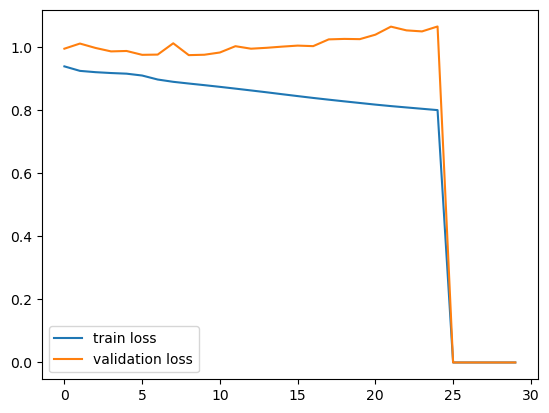

In [29]:
plt.figure()
plt.plot(train_losses[0:30], label='train loss')
plt.plot(val_losses[0:30], label='validation loss')
plt.legend()

# 测试模型

In [30]:
model = ResNet50(num_classes = 3)
model.to(device);
state_dict = torch.load(f'./ResNetcheckpoints_label60/ResNet_20000.pth', map_location=device)
# state_dict = torch.load(f'./checkpoints/transformer_334000.pth', map_location=device)
model.load_state_dict(state_dict)
model.eval()
all_targets = []
all_predictions = []

for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)    
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

accuracy_score: 0.33806679766779274
              precision    recall  f1-score   support

           0     0.3406    0.4401    0.3840     89423
           1     0.6506    0.1413    0.2321    142203
           2     0.2772    0.5789    0.3749     78295

    accuracy                         0.3381    309921
   macro avg     0.4228    0.3868    0.3304    309921
weighted avg     0.4669    0.3381    0.3120    309921



In [31]:
# model = torch.load('best_val_model_pytorch',map_location=device)
all_targets = []
all_predictions = []

for inputs, targets in train_loader:

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions) 
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

accuracy_score: 0.3164041006631722
              precision    recall  f1-score   support

           0     0.2908    0.4178    0.3429    551855
           1     0.7112    0.1572    0.2575   1259893
           2     0.2462    0.5861    0.3467    536360

    accuracy                         0.3164   2348108
   macro avg     0.4161    0.3870    0.3157   2348108
weighted avg     0.5062    0.3164    0.2979   2348108

